In [19]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm.auto import tqdm
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [6]:
BERT_OUTPUT_DIR = 'classification_report/distilbert_classification_model'

DATA_FILENAME = '../news_datasets/full_training_dataset.csv' 
VECTORIZER_FILENAME_PKL = 'classification_report/tfidf_vectorizer.pkl'
ENCODER_FILENAME_PKL = 'classification_report/bert_label_encoder.pkl'

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
df = pd.read_csv(DATA_FILENAME)

X_full_text = df['Full Text']
y_labels = df['llm_category']

with open(VECTORIZER_FILENAME_PKL, 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

with open(ENCODER_FILENAME_PKL, 'rb') as f:
    label_encoder = pickle.load(f)

y_encoded_full = label_encoder.transform(y_labels)

In [ ]:
bert_model_full = DistilBertForSequenceClassification.from_pretrained(BERT_OUTPUT_DIR).to(DEVICE)
bert_tokenizer = DistilBertTokenizerFast.from_pretrained(BERT_OUTPUT_DIR)

print("✅ All components (Dataset, TF-IDF, BERT, Encoder) are loading and ready.")

✅ All composants (Dataset, TF-IDF, BERT, Encoder) are loading and ready.


In [14]:
BERT_BASE_MODEL = bert_model_full.distilbert 

def get_bert_embeddings(texts, model, tokenizer, device):
    """Extracts the token [CLS] embedding to represent the entire document."""
    all_embeddings = []
    
    # Création d'un DataLoader pour le traitement par lots
    inputs = tokenizer(list(texts), max_length=512, truncation=True, padding=True, return_tensors='pt')
    dataset = torch.utils.data.TensorDataset(inputs['input_ids'], inputs['attention_mask'])
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=16) # Batch size 16 ou 32

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extraction Embeddings BERT"):
            input_ids, attention_mask = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            
            # Récupération des outputs bruts du corps de BERT
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # L'embedding du token [CLS] (position 0) représente le document entier
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(cls_embedding)

    return np.concatenate(all_embeddings, axis=0)

In [16]:
X_tfidf = tfidf_vectorizer.transform(X_full_text)
embeddings_tfidf = X_tfidf.toarray()
print(f"TF-IDF Embeddings extracts : {embeddings_tfidf.shape}")

# --- Extraction of Embeddings BERT ---
embeddings_bert = get_bert_embeddings(
    X_full_text, 
    BERT_BASE_MODEL,
    bert_tokenizer, 
    DEVICE
)
print(f"BERT Embeddings extracts : {embeddings_bert.shape}")

TF-IDF Embeddings extracts : (999, 5000)


Extraction Embeddings BERT: 100%|██████████| 63/63 [00:09<00:00,  6.88it/s]

BERT Embeddings extracts : (999, 768)



Calcul de t-SNE pour BERT...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 999 samples in 0.001s...
[t-SNE] Computed neighbors for 999 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 999 / 999
[t-SNE] Mean sigma: 1.587143
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.759041
[t-SNE] KL divergence after 1000 iterations: 0.516665


/tmp/ipykernel_69173/2015866842.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


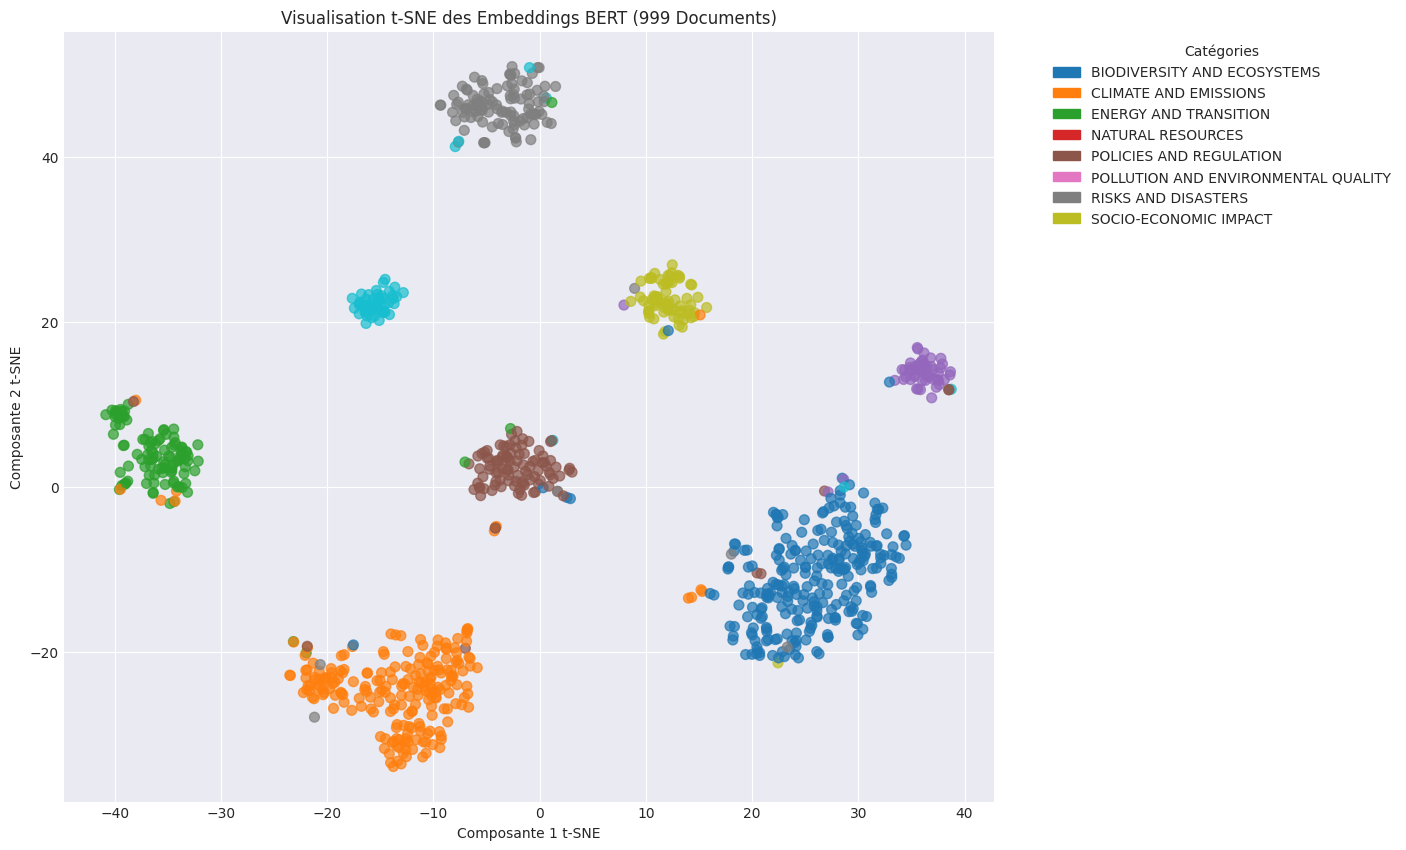

In [24]:
n_components = 2
plt.style.use('seaborn-v0_8-darkgrid')

# 1. BERT Vizualisation
print("\nCalcul de t-SNE pour BERT...")
# Use TSNE on BERT embeddings (dimension 768)
tsne_bert = TSNE(n_components=n_components, random_state=42, perplexity=30, n_jobs=-1, verbose=1)
reduced_bert = tsne_bert.fit_transform(embeddings_bert)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    reduced_bert[:, 0], 
    reduced_bert[:, 1], 
    c=y_encoded_full, 
    cmap='tab10', 
    alpha=0.7,
    s=50 # Dot size
)
plt.title("Visualisation t-SNE des Embeddings BERT (999 Documents)")
plt.xlabel("Composante 1 t-SNE")
plt.ylabel("Composante 2 t-SNE")

cmap = plt.cm.get_cmap('tab10')
legend_handles = []
for i, category_name in enumerate(label_encoder.classes_):
    # mpatches.Patch creates a colored square that will be the legend element
    color = cmap(i / len(label_encoder.classes_)) # Retrieves the color for each class
    patch = mpatches.Patch(color=color, label=category_name)
    legend_handles.append(patch)

# Use the manual handles for the legend
plt.legend(
    handles=legend_handles, 
    title="Catégories", 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left'
)
plt.show()


Calcul de t-SNE pour TF-IDF...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 999 samples in 0.000s...
[t-SNE] Computed neighbors for 999 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 999 / 999
[t-SNE] Mean sigma: 0.188691
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.477608
[t-SNE] KL divergence after 1000 iterations: 1.474398


/tmp/ipykernel_69173/1904448183.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


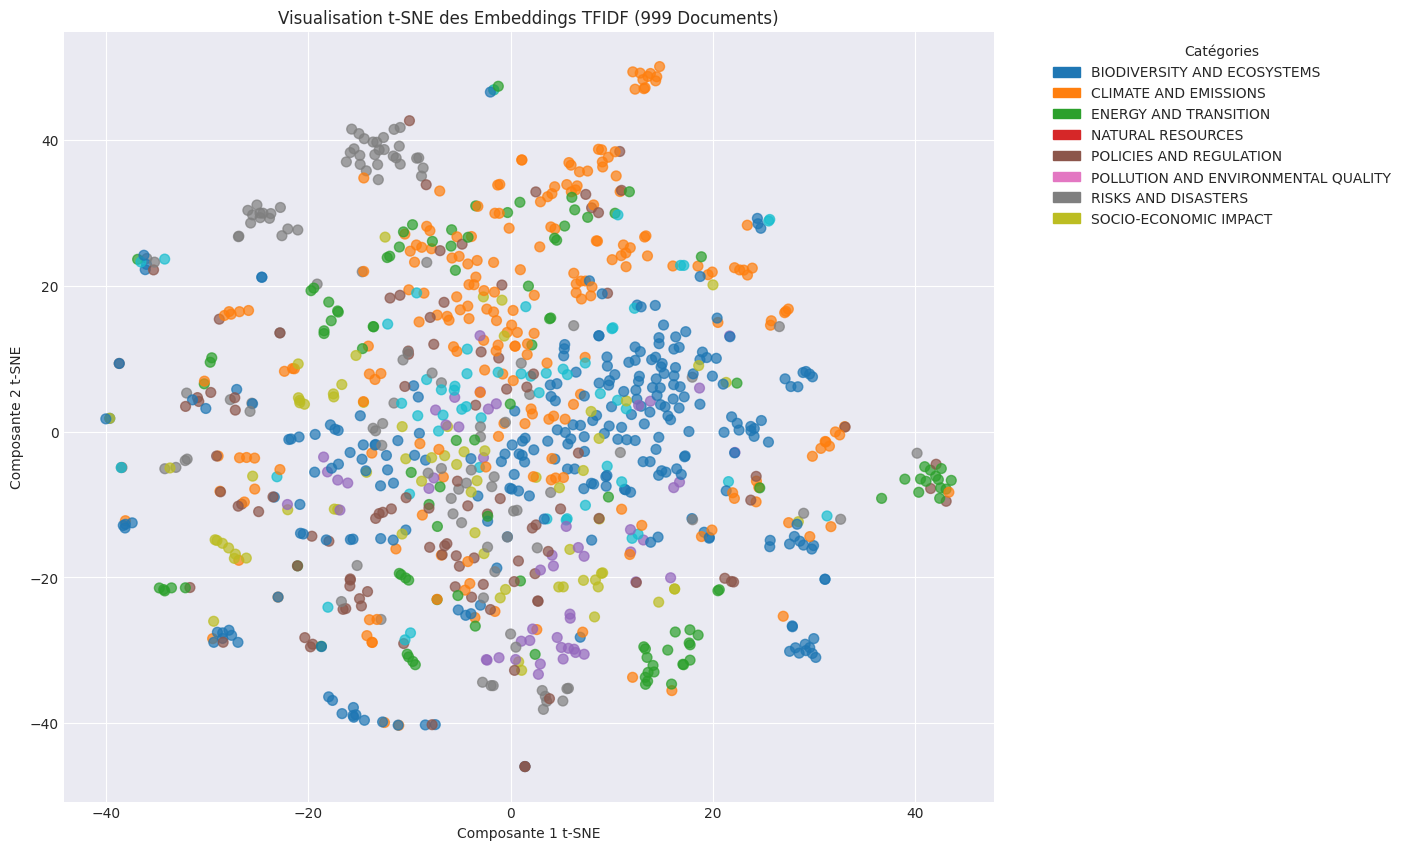

In [25]:
# --- Vizualisation TF-IDF ---
print("\nCalcul de t-SNE pour TF-IDF...")

# Reduction to 100 principal components to accelerate t-SNE
pca_tfidf = PCA(n_components=100, random_state=42).fit_transform(embeddings_tfidf)

# 2. Reduction to 2D with t-SNE
tsne_tfidf = TSNE(n_components=2, random_state=42, perplexity=30, n_jobs=-1, verbose=1)
reduced_tfidf = tsne_tfidf.fit_transform(pca_tfidf)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    reduced_tfidf[:, 0], 
    reduced_tfidf[:, 1], 
    c=y_encoded_full, 
    cmap='tab10', 
    alpha=0.7,
    s=50 # Dot size
)
plt.title("Visualisation t-SNE des Embeddings TFIDF (999 Documents)")
plt.xlabel("Composante 1 t-SNE")
plt.ylabel("Composante 2 t-SNE")

cmap = plt.cm.get_cmap('tab10')
legend_handles = []
for i, category_name in enumerate(label_encoder.classes_):
    color = cmap(i / len(label_encoder.classes_))
    patch = mpatches.Patch(color=color, label=category_name)
    legend_handles.append(patch)

plt.legend(
    handles=legend_handles, 
    title="Catégories", 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left'
)
plt.show()